In [64]:
import torch
import diffusers
from feature_store import FeatureStore
from utils import register_attention_control
from feature_store import show_cross_attention, show_self_attention_comp

pipe = diffusers.StableDiffusionPipeline.from_pretrained("Lykon/DreamShaper").to("cuda",torch.float16)
#pipe.set_attention_slice(8) # to extract attention maps we cant use xformers, this will allow us to spare memory


unet/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/ubuntu/.local/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [2]:
batch_size=1
width=768
height=768
steps = 25
scheduler = diffusers.EulerAncestralDiscreteScheduler

prompt = "a knight with a large sword, artstation"

feature_store = FeatureStore(batch_size=batch_size, width=width, height=height, store_all_steps=False, store_self=False)
register_attention_control(pipe, feature_store)
pipe.scheduler = scheduler.from_config(pipe.scheduler.config)

AttributeError: 'AttnProcessor' object has no attribute 'slice_size'

  0%|          | 0/25 [00:00<?, ?it/s]

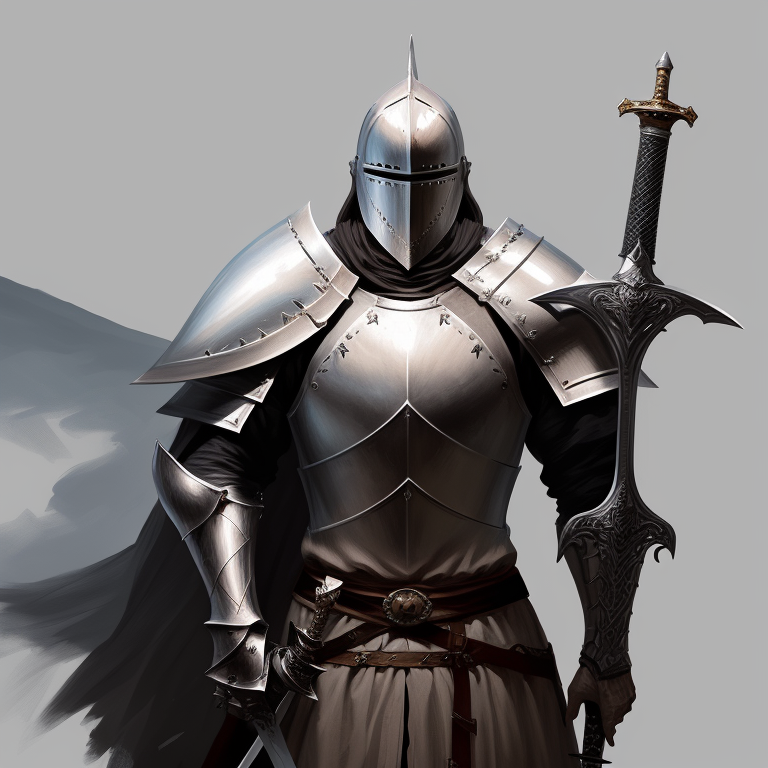

In [3]:
# generate something
images = pipe(prompt, num_inference_steps=steps, height=height, width=width).images

# display image
images[0]

# get attention maps

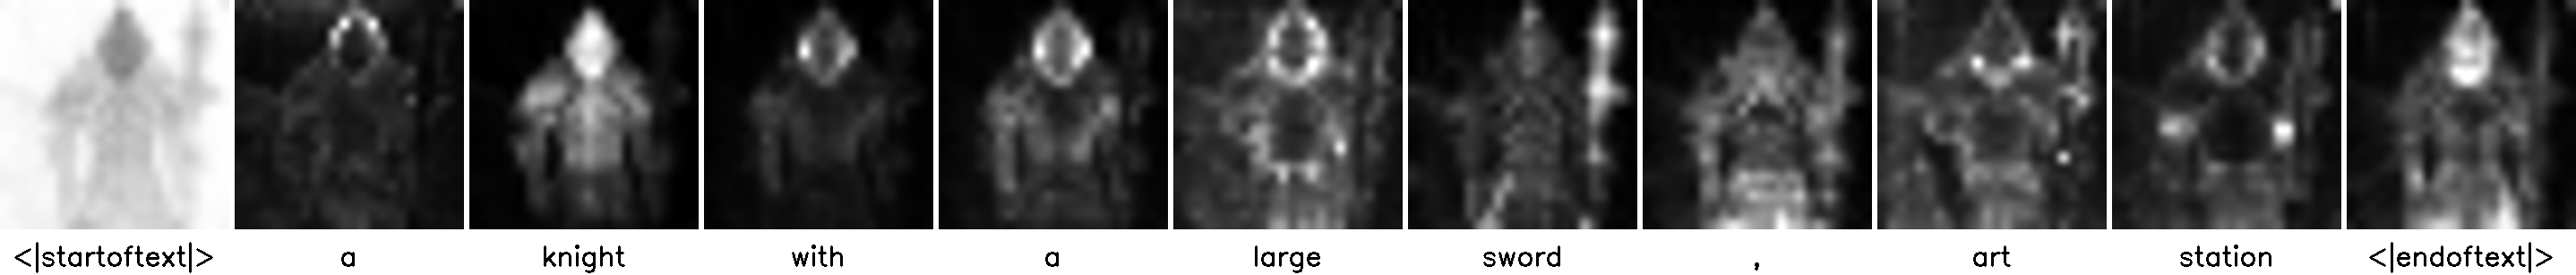

In [4]:
# view cross attn maps
from feature_store import show_cross_attention

show_cross_attention(
                pipe.tokenizer,
                prompt, 
                feature_store,
                resolution_to_view=None,
                location="up", 
                cond_batch=True, 
                batch_size=1,
                layer_num=1, 
                head_num="all", 
                # layer_num=0, 
                # head_num=7, 
                #step_num=10
)

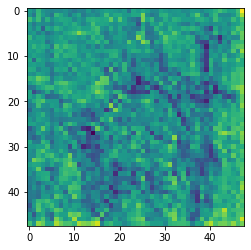

In [5]:
# view conv features
from feature_store import show_conv_feature_maps
show_conv_feature_maps(feature_store, 
                       batch_size, 
                       resolution_to_view=48, 
                       location="down", 
                       cond_batch=True,
                           steps=25,
                            #step_num=24,
                            layer_num=1,# put "all" to take the mean
                           channel_num=2, # put "all" to take the mean
                           )

In [ ]:
from feature_store import show_self_attention_comp

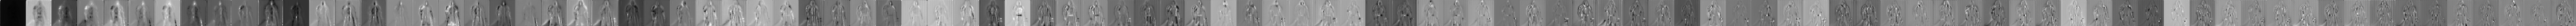

In [27]:
import torch.nn.functional as F
import numpy as np
from PIL import Image
import utils
show_self_attention_comp(
                feature_store,
                resolution_to_view=48,
                location="up", 
                cond_batch=True, 
                batch_size=1,
                max_com=100,
                #layer_num=1, 
                #head_num="all", 
                # layer_num=0, 
                # head_num=7, 
                #step_num=10
)

In [6]:
from feature_store import show_self_attn_output

In [10]:
out = show_self_attn_output(
                feature_store,
                resolution_to_view=48,
                location="up", 
                cond_batch=True, 
                batch_size=1,
                step_num=None
)

torch.Size([48, 48, 640])

In [41]:
import numpy as np
a,b,c = out.shape
u, s, vh = np.linalg.svd(out.reshape(a*b,c).numpy().astype(np.float32) - np.mean(out.reshape(a*b,c).numpy(), axis=1, keepdims=True))

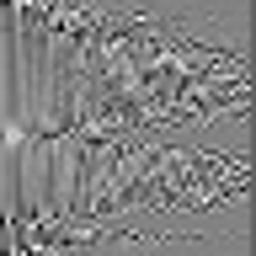

In [24]:
import utils
from PIL import Image
resolution_to_view=48
images = []
for i in range(1):
    image = u[i].reshape(resolution_to_view, resolution_to_view)
    image = image - image.min()
    image = 255 * image / image.max()
    image = np.repeat(np.expand_dims(image, axis=2), 3, axis=2).astype(np.uint8)
    image = Image.fromarray(image).resize((256, 256))
    image = np.array(image)
    images.append(image)
utils.view_images(np.concatenate(images, axis=1))

In [31]:
import matplotlib.pyplot as plt

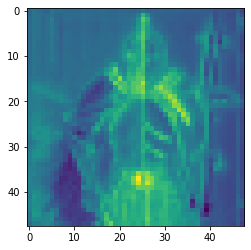

In [36]:
plt.imshow(out2[:,:,4])

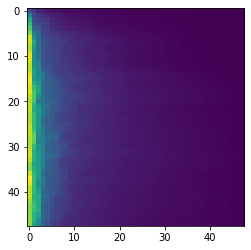

In [39]:
plt.imshow(s)

In [81]:
l = u.T[15].reshape(48,48)

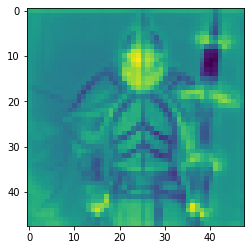

In [91]:
plt.imshow(l)

In [90]:
plt.savefig("myfig.png")

<Figure size 432x288 with 0 Axes>

In [92]:
plt.imsave("myfig.png",l)

In [93]:
u.T.shape

(2304, 2304)

In [105]:
full_image = np.zeros((2304,2304,3))
for i in range(u.T.shape[0]):
    l = u.T[i].reshape(48,48)
    loc = f"./samples/myfig{i}.png"
    plt.imsave(loc,l)
    img = Image.open(loc).convert("RGB")
    img = np.array(img)
    row = i//48
    col = i%48
    full_image[row*48:(row+1)*48,col*48:(col+1)*48,:] = img
    

In [108]:
final_img = Image.fromarray(full_image.astype(np.uint8))

In [111]:
final_img.save("eigenknights.png")

In [131]:
R = u.T[0].reshape(48,48)
G = u.T[1].reshape(48,48)
B = u.T[2].reshape(48,48)

R = R - R.min()
G = G - G.min()
B = B - B.min()

R = R/R.max()
G = G/G.max()
B = B/B.max()

In [137]:
out = np.stack((R,G,B)) * 255

In [138]:
out = out.transpose(1,2,0)

In [139]:
pilimg = Image.fromarray(out.astype(np.uint8))

In [140]:
out.shape

(48, 48, 3)

In [142]:
pilimg.save("pilimg.png")

In [143]:
a = [torch.randn(5,5) for _ in range(5)]

In [145]:
torch.sum(a)

TypeError: sum(): argument 'input' (position 1) must be Tensor, not list

In [18]:
toks = pipe.tokenizer("billy and his dog",return_tensors='pt').input_ids.cuda()
j=pipe.text_encoder(toks, output_hidden_states=True)

In [29]:
pipe.tokenizer.eos_token_id

49407

In [9]:

# for module in pipe.unet.named_modules():
#     if "attn1" in module[0]:
        

In [66]:
# hooking queries
pipe.unet.down_blocks[1].attentions[1].transformer_blocks[0].attn1.to_q.register_forward_hook(down_hook)
pipe.unet.up_blocks[2].attentions[2].transformer_blocks[0].attn1.to_q.register_forward_hook(up_hook)
# hooking keys
#pipe.unet.down_blocks[1].attentions[1].transformer_blocks[0].attn1.to_k.register_forward_hook(down_hook)
#pipe.unet.up_blocks[2].attentions[2].transformer_blocks[0].attn1.to_k.register_forward_hook(up_hook)


# hooking incoming hidden states
def incoming_down_hook(module, input):
    the_store.down_feature_store[the_store.cur_timestep] = input[0].clone().cpu()
    
def incoming_up_hook(module, input):
    the_store.up_feature_store[the_store.cur_timestep] = input[0].clone().cpu()

# pipe.unet.down_blocks[1].attentions[1].transformer_blocks[0].attn1.to_out[0].register_forward_pre_hook(incoming_down_hook)
# pipe.unet.up_blocks[2].attentions[2].transformer_blocks[0].attn1.to_out[0].register_forward_pre_hook(incoming_up_hook)


In [67]:
torch.manual_seed(6)
img = pipe("HD picture of a dog", height=768, width=768).images

  0%|          | 0/50 [00:00<?, ?it/s]

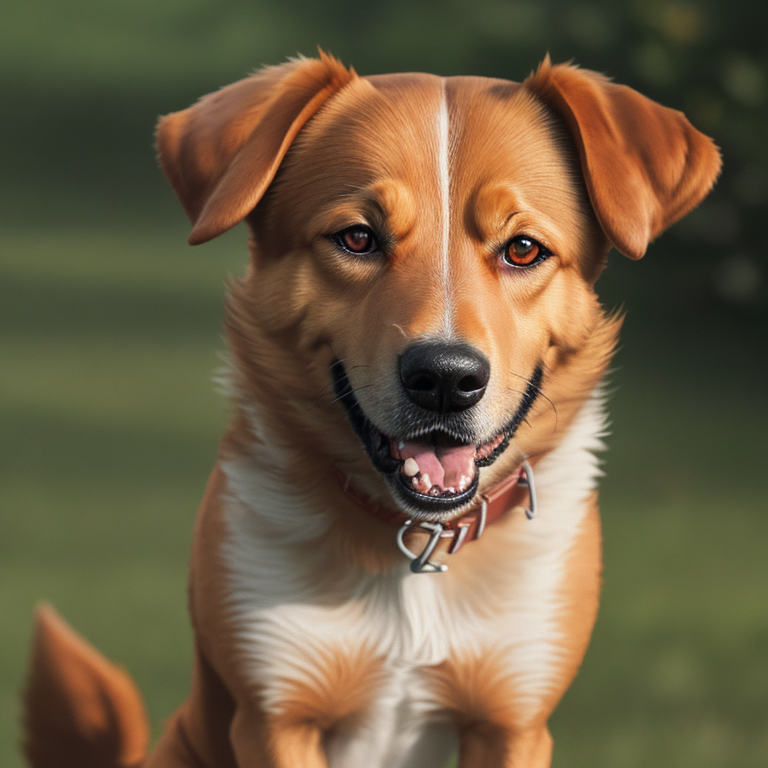

In [68]:
img[0]

In [69]:
test = the_store.down_feature_store[49][1]
#test = the_store.up_feature_store[49][1]

In [149]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import math
from sklearn import cluster
from types import MethodType

def plot_svd_images(feats, save_name):
    u,s,v = torch.linalg.svd(feats.float())
    dim = int(u.shape[-1] ** 0.5)
    u = u.reshape(dim,dim,-1).numpy()
    full_img = np.zeros((u.shape[-1],u.shape[-1],3))
    for i in range(u.shape[-1]):
        col = (i % dim)*dim
        row = (i // dim) * dim
        plt.imsave("temp.png",u[:,:,i])
        image = Image.open("temp.png").convert("RGB")
        np_img = np.array(image)
        full_img[row:row+dim, col:col+dim, :] = np_img
    plots = Image.fromarray(full_img.astype(np.uint8))
    plots.save(f"{save_name}")
    
def plot_feats(feats, save_name):
    dim = int(feats.shape[0] ** 0.5)
    feats = feats.reshape(dim,dim,-1)
    full_img = np.zeros((feats.shape[0]**2,feats.shape[0]**2,3))
    for i in range(feats.shape[-1]):
        col = (i % dim)*dim
        row = (i // dim) * dim
        plt.imsave("temp.png",feats[:,:,i])
        image = Image.open("temp.png").convert("RGB")
        np_img = np.array(image)
        full_img[row:row+dim, col:col+dim, :] = np_img
    plots = Image.fromarray(full_img.astype(np.uint8))
    plots.save(f"{save_name}")

colors = [
np.array([255,0,0]),
np.array([0,255,0]),
np.array([0,0,255]),
np.array([255,255,0]),
np.array([0,255,255]),
np.array([255,0,255]),
np.array([127,0,255]),
np.array([128,128,128]),
]

def kmeans_cluster(feats, save_name, n_clusters=4):
    kmeans = cluster.KMeans(n_clusters=n_clusters)
    kmeans.fit(feats)
    dim = int(feats.shape[0] ** 0.5)
    marked_image = np.zeros((dim,dim,3))
    for i in range(feats.shape[0]):
        cluster_num = kmeans.predict(feats[i:i+1]).item()
        color = colors[cluster_num]
        col = i % dim
        row = i // dim
        marked_image[row,col,:] = color
    
    marked_image = Image.fromarray(marked_image.astype(np.uint8))
    marked_image.save(f"{save_name}")
    
    return marked_image


def run_tests(model_path, prompt="cinematic shot of a woman at a desk looking out a window hd, melancholy", 
              sd_params={"height":512,"width":512}, 
              seed=124, 
              #feats=["query","key","incoming","self_maps"],
              #steps_to_check=[5,20,50], 
              #modes=["uncond","cond"], 
              #sides=['down','up'], 
              
                feats=["incoming","query"],
              steps_to_check=[5,20,50], 
              modes=["cond"], 
              sides=['up','down'], 
              n_clusters=5,
              block_num=1, 
              attn_num=-1, 
              transformer_num=0 # 1.5/2.0 only have 1 layer anyway
             ):
    
    # warning: doing svd on the higher resolution blocks will eat up all your vram
    
    modes_dict = {"uncond":0,
                 "cond":1}
    
    class Store:
        def __init__(self):
            self.cur_timestep = None
            self.down_feature_store = {}
            self.up_feature_store = {}

    the_store = Store()
    

    def unet_time_hook(module, input):
        the_store.cur_timestep = int((1 - input[1].item()/1000) * 50)

    def make_hook(module, feat="query", place="down"):
        
        def attention_map_hook(*inputs):
            # remove self
            inputs = inputs[1:]
            #now here we will have 8 heads
            output = module.old_get_attention_scores(*inputs)
            output_to_save=output.clone().cpu()
            uncond, cond = output_to_save.chunk(2)
            output_to_save=torch.cat([uncond.mean(0,keepdim=True),cond.mean(0,keepdim=True)])
            if "down" in place:
                if the_store.down_feature_store.get(feat,None) is None:
                    the_store.down_feature_store[feat] = {}
                the_store.down_feature_store[feat][the_store.cur_timestep] = output_to_save
            elif "up" in place:
                if the_store.up_feature_store.get(feat,None) is None:
                    the_store.up_feature_store[feat] = {}
                the_store.up_feature_store[feat][the_store.cur_timestep] = output_to_save
                
            return output
        
        def feat_hook(module, input, output):
            if "down" in place:
                if the_store.down_feature_store.get(feat,None) is None:
                    the_store.down_feature_store[feat] = {}
                the_store.down_feature_store[feat][the_store.cur_timestep] = output.clone().cpu()
            elif "up" in place:
                if the_store.up_feature_store.get(feat,None) is None:
                    the_store.up_feature_store[feat] = {}
                the_store.up_feature_store[feat][the_store.cur_timestep] = output.clone().cpu()

        def incoming_feat_hook(module, input):
            if "down" in place:
                if the_store.down_feature_store.get(feat,None) is None:
                    the_store.down_feature_store[feat] = {}
                the_store.down_feature_store[feat][the_store.cur_timestep] = input[0].clone().cpu()
            elif "up" in place:
                if the_store.up_feature_store.get(feat,None) is None:
                    the_store.up_feature_store[feat] = {}
                the_store.up_feature_store[feat][the_store.cur_timestep] = input[0].clone().cpu()
        
        if feat in ["incoming"]:
            module.register_forward_pre_hook(incoming_feat_hook)
        elif feat in ["query","key"]:
            module.register_forward_hook(feat_hook)
        elif feat in ['self_maps', "cross_maps"]:
            module.old_get_attention_scores = module.get_attention_scores
            module.get_attention_scores = MethodType(attention_map_hook, module)
        

    pipe = diffusers.StableDiffusionPipeline.from_pretrained(model_path).to("cuda",torch.float16)
    pipe.unet.register_forward_pre_hook(unet_time_hook)
    torch.manual_seed(seed)
    
    for feat in feats:
        if "query" in feat:
            make_hook(pipe.unet.down_blocks[block_num].attentions[attn_num].transformer_blocks[0].attn1.to_q, feat=feat, place="down")
            make_hook(pipe.unet.up_blocks[3-block_num].attentions[attn_num].transformer_blocks[0].attn1.to_q, feat=feat, place="up")
        if "key" in feat:
            make_hook(pipe.unet.down_blocks[block_num].attentions[attn_num].transformer_blocks[0].attn1.to_k, feat=feat, place="down")
            make_hook(pipe.unet.up_blocks[3-block_num].attentions[attn_num].transformer_blocks[0].attn1.to_k, feat=feat, place="up")
        if "incoming" in feat:
            make_hook(pipe.unet.down_blocks[block_num].attentions[attn_num].transformer_blocks[0].attn1.to_out[0], feat=feat, place="down")
            make_hook(pipe.unet.up_blocks[3-block_num].attentions[attn_num].transformer_blocks[0].attn1.to_out[0], feat=feat, place="up")
        if "self_maps" in feat:
            make_hook(pipe.unet.down_blocks[block_num].attentions[attn_num].transformer_blocks[0].attn1, feat=feat, place="down")
            make_hook(pipe.unet.up_blocks[3-block_num].attentions[attn_num].transformer_blocks[0].attn1, feat=feat, place="up")
        if "cross_maps" in feat:
            make_hook(pipe.unet.down_blocks[block_num].attentions[attn_num].transformer_blocks[0].attn2, feat=feat, place="down")
            make_hook(pipe.unet.up_blocks[3-block_num].attentions[attn_num].transformer_blocks[0].attn2, feat=feat, place="up")
    
    img = pipe(prompt, height=768, width=768).images
    for feat in feats:
        for step in steps_to_check:
            for mode in modes:
                for side in sides:
                    idx = modes_dict[mode]
                    if "down" in side:
                        feature = the_store.down_feature_store[feat][step-1][idx]
                    else:
                        feature = the_store.up_feature_store[feat][step-1][idx]
                    
                    filename = f"{feat}_{side}_{mode}_{step}.png"
                    plot_feats(feature, filename)
                    
                    filename = f"svd_{feat}_{side}_{mode}_{step}.png"
                    plot_svd_images(feature, filename)
                    
                    filename = f"segment_{feat}_{side}_{mode}_{step}.png"
                    kmeans_cluster(feature,filename,n_clusters=n_clusters)
                
            
            
            
    
    


In [150]:
run_tests("Lykon/DreamShaper")

unet/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/ubuntu/.local/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

In [1]:
import torch

In [18]:
a = torch.randn(4,70,768)

In [20]:
indices = torch.randint(0, 70, (4,17))

In [21]:
a[:,indices].shape

torch.Size([4, 4, 17, 768])

In [27]:
pooled = torch.randn(4,70,768)
pooled_embeds = []
for j in range(pooled.shape[0]):
    indices = torch.randint(0, 70, (17,))
    pooled_subset = pooled[j,indices]
    pooled_embeds.append(pooled_subset)
pooled = torch.stack(pooled_embeds, dim=0)

In [28]:
pooled.shape

torch.Size([4, 17, 768])